<a href="https://colab.research.google.com/github/wgraysonp/Deep_RL/blob/main/Reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 37.6 MB/s eta 0:00:00


In [6]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

import numpy as np
from collections import deque
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Define the policy network

In [95]:
class Policy(nn.Module):

    def __init__(self, state_size=4, action_size=2, seed=0, width=10):
        super().__init__()
        torch.manual_seed(seed)
        self.l1 = nn.Linear(state_size, width)
        self.l2 = nn.Linear(width, action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        dist = self.forward(state)
        m = Categorical(dist)
        action = m.sample()
        return action.item(), m.log_prob(action)

Define agent class

In [96]:

class ReinforceAgent:
    def __init__(
        self,
        env: gym.Env,
        lr: float,
        policy: nn.Module,
        optimizer: torch.optim.Optimizer,
        gamma: float = 0.995,
    ):
        self.env = env
        self.lr = lr
        self.gamma = gamma
        self.policy = policy
        self.optimizer = optimizer(policy.parameters(), lr=self.lr)

    def train(self, episodes=100, samples=10):
        avg_reward = deque(maxlen=100)
        env = self.env
        policy = self.policy
        optimizer = self.optimizer
        for episode in tqdm(range(1, episodes + 1)):
            state, _ = env.reset()
            env.render()
            saved_log_probs = []
            rewards = []
            for t in range(samples):
                action, log_prob = policy.act(state)
                saved_log_probs.append(log_prob)
                state, reward, truncated, _, _ = env.step(action)
                rewards.append(reward)
                if truncated:
                    break
            discounts = [self.gamma**i for i in range(len(rewards))]
            R = [a*b for a, b in zip(discounts, rewards)]
            avg_reward.append(sum(rewards))
            policy_loss = []
            for i, log_prob in enumerate(saved_log_probs):
                R_sum = sum(R[i:])
                policy_loss.append(-log_prob*R_sum)
            policy_loss = torch.cat(policy_loss).sum()


            optimizer.zero_grad()
            policy_loss.backward()
            optimizer.step()

            if episode % 10 == 0:
                print("Episode: {:d}, Average Reward: {:.1f}".format(episode, np.mean(avg_reward)))

        self.env.close()

In [97]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
print(env.observation_space.shape)
print(env.action_space)

(4,)
Discrete(2)


In [104]:
policy = Policy(state_size=4, action_size=2, seed=0, width=8)
agent = ReinforceAgent(env, lr=1e-2, policy=policy, optimizer = torch.optim.Adam)

In [105]:
agent.train(episodes=1000, samples=200)

  1%|▏         | 13/1000 [00:00<00:26, 37.11it/s]

Episode: 10, Average Reward: 22.1


  2%|▎         | 25/1000 [00:00<00:27, 35.05it/s]

Episode: 20, Average Reward: 21.1


  3%|▎         | 33/1000 [00:00<00:28, 34.15it/s]

Episode: 30, Average Reward: 22.4


  4%|▍         | 45/1000 [00:01<00:28, 33.40it/s]

Episode: 40, Average Reward: 23.7


  5%|▌         | 53/1000 [00:01<00:31, 30.49it/s]

Episode: 50, Average Reward: 24.9


  6%|▋         | 63/1000 [00:01<00:31, 29.37it/s]

Episode: 60, Average Reward: 25.4


  7%|▋         | 72/1000 [00:02<00:39, 23.38it/s]

Episode: 70, Average Reward: 28.2


  8%|▊         | 83/1000 [00:03<00:52, 17.59it/s]

Episode: 80, Average Reward: 32.4


  9%|▉         | 90/1000 [00:03<01:00, 15.09it/s]

Episode: 90, Average Reward: 35.3


 10%|█         | 104/1000 [00:04<00:53, 16.82it/s]

Episode: 100, Average Reward: 38.9


 11%|█         | 112/1000 [00:05<01:01, 14.36it/s]

Episode: 110, Average Reward: 42.4


 12%|█▏        | 121/1000 [00:05<00:59, 14.67it/s]

Episode: 120, Average Reward: 46.5


 13%|█▎        | 131/1000 [00:06<01:09, 12.50it/s]

Episode: 130, Average Reward: 52.2


 14%|█▍        | 143/1000 [00:07<00:49, 17.35it/s]

Episode: 140, Average Reward: 54.7


 15%|█▌        | 151/1000 [00:07<01:06, 12.70it/s]

Episode: 150, Average Reward: 57.5


 16%|█▌        | 161/1000 [00:09<01:51,  7.56it/s]

Episode: 160, Average Reward: 64.2


 17%|█▋        | 170/1000 [00:10<01:20, 10.35it/s]

Episode: 170, Average Reward: 67.5


 18%|█▊        | 181/1000 [00:11<01:34,  8.64it/s]

Episode: 180, Average Reward: 71.2


 19%|█▉        | 191/1000 [00:13<01:57,  6.90it/s]

Episode: 190, Average Reward: 78.5


 20%|██        | 201/1000 [00:14<01:45,  7.55it/s]

Episode: 200, Average Reward: 83.2


 21%|██        | 211/1000 [00:15<01:45,  7.50it/s]

Episode: 210, Average Reward: 91.8


 22%|██▏       | 222/1000 [00:16<01:23,  9.29it/s]

Episode: 220, Average Reward: 97.1


 23%|██▎       | 230/1000 [00:17<01:18,  9.78it/s]

Episode: 230, Average Reward: 98.2


 24%|██▍       | 241/1000 [00:19<01:47,  7.08it/s]

Episode: 240, Average Reward: 107.5


 25%|██▌       | 250/1000 [00:20<02:12,  5.65it/s]

Episode: 250, Average Reward: 115.8


 26%|██▌       | 260/1000 [00:22<03:12,  3.85it/s]

Episode: 260, Average Reward: 122.9


 27%|██▋       | 271/1000 [00:25<02:01,  6.02it/s]

Episode: 270, Average Reward: 132.8


 28%|██▊       | 280/1000 [00:26<01:50,  6.50it/s]

Episode: 280, Average Reward: 138.4


 29%|██▉       | 290/1000 [00:27<01:47,  6.60it/s]

Episode: 290, Average Reward: 140.2


 30%|███       | 301/1000 [00:29<01:31,  7.61it/s]

Episode: 300, Average Reward: 142.4


 31%|███       | 312/1000 [00:30<01:13,  9.31it/s]

Episode: 310, Average Reward: 140.1


 32%|███▏      | 321/1000 [00:31<01:05, 10.30it/s]

Episode: 320, Average Reward: 139.4


 33%|███▎      | 331/1000 [00:32<01:05, 10.23it/s]

Episode: 330, Average Reward: 138.9


 34%|███▍      | 340/1000 [00:34<01:36,  6.81it/s]

Episode: 340, Average Reward: 136.5


 35%|███▌      | 350/1000 [00:36<02:10,  4.97it/s]

Episode: 350, Average Reward: 137.7


 36%|███▌      | 361/1000 [00:38<01:31,  6.95it/s]

Episode: 360, Average Reward: 136.5


 37%|███▋      | 370/1000 [00:39<01:43,  6.11it/s]

Episode: 370, Average Reward: 134.5


 38%|███▊      | 381/1000 [00:41<01:52,  5.48it/s]

Episode: 380, Average Reward: 136.1


 39%|███▉      | 391/1000 [00:43<01:57,  5.20it/s]

Episode: 390, Average Reward: 140.6


 40%|████      | 401/1000 [00:45<01:53,  5.27it/s]

Episode: 400, Average Reward: 145.6


 41%|████      | 410/1000 [00:47<02:10,  4.52it/s]

Episode: 410, Average Reward: 152.2


 42%|████▏     | 420/1000 [00:49<02:12,  4.37it/s]

Episode: 420, Average Reward: 157.2


 43%|████▎     | 431/1000 [00:51<01:27,  6.52it/s]

Episode: 430, Average Reward: 164.1


 44%|████▍     | 441/1000 [00:52<01:27,  6.36it/s]

Episode: 440, Average Reward: 166.3


 45%|████▌     | 451/1000 [00:54<01:22,  6.66it/s]

Episode: 450, Average Reward: 166.9


 46%|████▌     | 461/1000 [00:55<01:15,  7.09it/s]

Episode: 460, Average Reward: 167.3


 47%|████▋     | 471/1000 [00:57<01:20,  6.58it/s]

Episode: 470, Average Reward: 164.6


 48%|████▊     | 481/1000 [00:59<01:25,  6.10it/s]

Episode: 480, Average Reward: 164.5


 49%|████▉     | 491/1000 [01:00<01:22,  6.15it/s]

Episode: 490, Average Reward: 159.9


 50%|█████     | 501/1000 [01:03<02:00,  4.15it/s]

Episode: 500, Average Reward: 160.2


 51%|█████     | 511/1000 [01:05<01:27,  5.57it/s]

Episode: 510, Average Reward: 160.5


 52%|█████▏    | 521/1000 [01:07<01:28,  5.40it/s]

Episode: 520, Average Reward: 164.2


 53%|█████▎    | 531/1000 [01:08<01:25,  5.47it/s]

Episode: 530, Average Reward: 167.4


 54%|█████▍    | 541/1000 [01:10<01:29,  5.11it/s]

Episode: 540, Average Reward: 173.0


 55%|█████▌    | 550/1000 [01:12<01:26,  5.23it/s]

Episode: 550, Average Reward: 177.0


 56%|█████▌    | 560/1000 [01:15<01:53,  3.88it/s]

Episode: 560, Average Reward: 181.3


 57%|█████▋    | 571/1000 [01:17<01:15,  5.66it/s]

Episode: 570, Average Reward: 186.9


 58%|█████▊    | 581/1000 [01:19<01:20,  5.20it/s]

Episode: 580, Average Reward: 190.0


 59%|█████▉    | 591/1000 [01:21<01:19,  5.15it/s]

Episode: 590, Average Reward: 195.1


 60%|██████    | 601/1000 [01:23<01:16,  5.18it/s]

Episode: 600, Average Reward: 195.8


 61%|██████    | 611/1000 [01:25<01:14,  5.23it/s]

Episode: 610, Average Reward: 196.7


 62%|██████▏   | 620/1000 [01:27<01:31,  4.17it/s]

Episode: 620, Average Reward: 197.5


 63%|██████▎   | 631/1000 [01:29<01:19,  4.63it/s]

Episode: 630, Average Reward: 198.6


 64%|██████▍   | 641/1000 [01:31<01:08,  5.26it/s]

Episode: 640, Average Reward: 197.8


 65%|██████▌   | 651/1000 [01:33<01:08,  5.09it/s]

Episode: 650, Average Reward: 197.8


 66%|██████▌   | 661/1000 [01:35<01:05,  5.14it/s]

Episode: 660, Average Reward: 197.7


 67%|██████▋   | 670/1000 [01:37<01:02,  5.28it/s]

Episode: 670, Average Reward: 199.1


 68%|██████▊   | 680/1000 [01:39<00:54,  5.87it/s]

Episode: 680, Average Reward: 198.1


 69%|██████▉   | 690/1000 [01:41<01:21,  3.79it/s]

Episode: 690, Average Reward: 197.2


 70%|███████   | 701/1000 [01:44<00:58,  5.15it/s]

Episode: 700, Average Reward: 196.8


 71%|███████   | 710/1000 [01:45<00:50,  5.78it/s]

Episode: 710, Average Reward: 195.6


 72%|███████▏  | 721/1000 [01:47<00:46,  5.95it/s]

Episode: 720, Average Reward: 193.1


 73%|███████▎  | 731/1000 [01:49<00:52,  5.11it/s]

Episode: 730, Average Reward: 193.1


 74%|███████▍  | 741/1000 [01:51<00:51,  5.00it/s]

Episode: 740, Average Reward: 193.8


 75%|███████▌  | 750/1000 [01:53<01:05,  3.81it/s]

Episode: 750, Average Reward: 192.2


 76%|███████▌  | 760/1000 [01:56<01:16,  3.14it/s]

Episode: 760, Average Reward: 192.4


 77%|███████▋  | 771/1000 [01:59<00:47,  4.82it/s]

Episode: 770, Average Reward: 192.4


 78%|███████▊  | 781/1000 [02:01<00:41,  5.31it/s]

Episode: 780, Average Reward: 193.4


 79%|███████▉  | 791/1000 [02:03<00:38,  5.48it/s]

Episode: 790, Average Reward: 193.4


 80%|████████  | 801/1000 [02:05<00:38,  5.17it/s]

Episode: 800, Average Reward: 193.8


 81%|████████  | 811/1000 [02:07<00:36,  5.24it/s]

Episode: 810, Average Reward: 195.1


 82%|████████▏ | 820/1000 [02:09<00:43,  4.16it/s]

Episode: 820, Average Reward: 197.6


 83%|████████▎ | 831/1000 [02:11<00:35,  4.75it/s]

Episode: 830, Average Reward: 197.6


 84%|████████▍ | 841/1000 [02:14<00:38,  4.09it/s]

Episode: 840, Average Reward: 197.6


 85%|████████▌ | 851/1000 [02:15<00:28,  5.27it/s]

Episode: 850, Average Reward: 199.1


 86%|████████▌ | 861/1000 [02:17<00:26,  5.22it/s]

Episode: 860, Average Reward: 199.1


 87%|████████▋ | 871/1000 [02:19<00:25,  5.12it/s]

Episode: 870, Average Reward: 199.1


 88%|████████▊ | 880/1000 [02:21<00:28,  4.19it/s]

Episode: 880, Average Reward: 199.1


 89%|████████▉ | 891/1000 [02:24<00:24,  4.53it/s]

Episode: 890, Average Reward: 200.0


 90%|█████████ | 901/1000 [02:26<00:18,  5.21it/s]

Episode: 900, Average Reward: 200.0


 91%|█████████ | 911/1000 [02:28<00:16,  5.32it/s]

Episode: 910, Average Reward: 200.0


 92%|█████████▏| 921/1000 [02:30<00:15,  5.20it/s]

Episode: 920, Average Reward: 200.0


 93%|█████████▎| 931/1000 [02:32<00:13,  5.27it/s]

Episode: 930, Average Reward: 200.0


 94%|█████████▍| 940/1000 [02:34<00:12,  4.86it/s]

Episode: 940, Average Reward: 200.0


 95%|█████████▌| 950/1000 [02:36<00:13,  3.64it/s]

Episode: 950, Average Reward: 200.0


 96%|█████████▌| 961/1000 [02:38<00:07,  5.16it/s]

Episode: 960, Average Reward: 200.0


 97%|█████████▋| 971/1000 [02:40<00:05,  5.15it/s]

Episode: 970, Average Reward: 200.0


 98%|█████████▊| 981/1000 [02:42<00:03,  5.13it/s]

Episode: 980, Average Reward: 200.0


 99%|█████████▉| 991/1000 [02:44<00:01,  5.19it/s]

Episode: 990, Average Reward: 200.0


100%|██████████| 1000/1000 [02:46<00:00,  6.01it/s]


Episode: 1000, Average Reward: 200.0


In [100]:
from ast import increment_lineno
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [101]:
def show_state(env, step=0, info=""):
  plt.figure(3)
  plt.clf()
  plt.imshow(env.render())
  plt.title("%s | Step: %s" % (step, info))
  plt.axis('off')

  display.clear_output(wait=True)
  display.display(plt.gcf())

KeyboardInterrupt: 

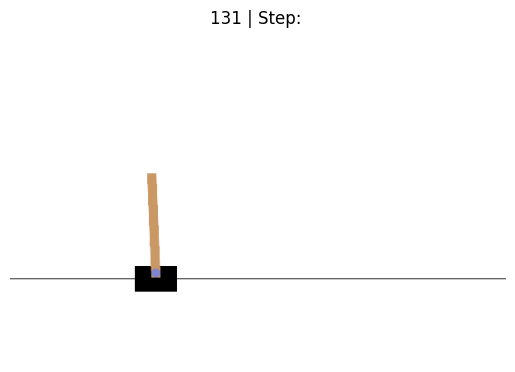

In [107]:
state, _ = env.reset()
for t in range(1000):
  action, _ = policy.act(state)
  env.render()
  state, reward, done, _, _ = env.step(action)
  show_state(env, step=t, info="")
  if done:
    break

env.close()
